<h1 style="text-align: center;"> Evaluación Módulo II: Predicción del precio inmobiliario.  </h1>
<p align="center">
  <img src="https://cdn.prod.website-files.com/649475f4d573d5d9d1522659/649475f4d573d5d9d1522705_logo-track-ciencia.webp" alt="Logo Track Ciencia">
</p>

**Contexto del caso**

El caso de uso trata sobre un conjunto de datos recolectados y proporcionados por el Institut Louis Bachelier (ILB) sobre el real estate en Francia en donde el objetivo se centra en una tarea de regresión para poder predecir costos estimados inmobiliarios.

**Objetivos de la evaluación**

- Realizar la limpieza, exploración y pre-procesamiento necesarios de los datos.
- Utilizar el 75% de los datos como conjunto de entrenamiento y el 25% como conjunto de validación.
- Elegir y justificar un modelo regresión adecuado al problema y a las evidencias analíticas 
- Realizar un resumen ejecutivo de nos más de dos parrafos incluyendo la interpretación y evaluación de los resultados.

***Nota: En el reto original se nos da datos con imagenes, estas se pueden omitir (No descartar para futuras pruebas con estos datos).***

**Descripción de los datos:**
Se trata de dos archivos CSV, uno con la características explicativas (X) y otro con la etiqueta (y).

La etiqueta (y) representa el precio en euros de bienes inmuebles en Francia. 

Las características (X) contienen:
- Un identificador del anuncio
- El tipo de propiedad (casa, apartamento, condominio, mansión...)
- La ubicación (latitud aproximada, longitud aproximada, ciudad, código postal, exposición, piso cuando proceda...)
- El tamaño (superficie habitable y superficie del terreno cuando proceda),
- El número de habitaciones, dormitorios, baños...
- Indicadores de eficiencia energética (energía y emisiones de gases de efecto invernadero)
- El número de fotos adjuntas al anuncio
- Indicadores de si hay sótano, balcón, aire acondicionado...

Además se presenta un diccionario de datos en formato xlsx

## Librerias

In [41]:
# Librerias para análisis
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
from sklearn import metrics
from scipy.stats import kurtosis

# Librerias para visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Funciones.

In [2]:
def describe_datos(df):
    unicos = []
    for col in df.columns:
        try:
            unicos.append(df[col].unique())
        except:
            unicos.append(np.array([df[col].iloc[0]]))  # fallback si falla
    unicos = pd.Series(unicos, index=df.columns)
    descripcion = pd.concat([df.dtypes, df.isna().sum(), df.nunique(), unicos], axis=1)
    descripcion.columns = ['dtypes', 'null', 'nunique', 'unique']
    return descripcion

In [3]:
def grafica_distribuciones(df):
    # Seleccionamos solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Definimos las dimensiones del grid de subplots de forma dinámica
    num_cols = len(numeric_cols)
    ncols = 3
    nrows = int(np.ceil(num_cols / ncols))
    
    # Crear los subplots
    fig, subplot = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))
    subplot = subplot.flatten() # Para iterar fácilmente

    # Graficamos
    for i, col in enumerate(numeric_cols):
        df[col].dropna().hist(bins=50, color='blue', alpha=0.7, ax=subplot[i], density=True)
        subplot[i].set_title(f'{col} - Distribución')
        subplot[i].set_xlabel(col)
        subplot[i].set_ylabel('Frecuencia')
        
    for j in range(i + 1, len(subplot)):
        subplot[j].set_visible(False)

    plt.tight_layout()
    plt.show()

## Lectura de datos y selección de caracteristicas.

#### Cargamos nuestra etiqueta (y)

In [4]:
# Variables respuesta
Ys = pd.read_csv('/Users/danielml/Documents/Computational/Curso_Bourbaki/Evaluacion_Modulo_2/Datos/y.csv')
print(Ys.shape)
Ys.head()

(37368, 2)


,id_annonce,price
0,35996577,355000.0
1,35811033,190000.0
2,35731841,39000.0
3,35886765,299000.0
4,35781137,478000.0


#### Cargamos nuestros features (X)

In [5]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('/Users/danielml/Documents/Computational/Curso_Bourbaki/Evaluacion_Modulo_2/Datos/x.csv')
print(X.shape)
X.head()

(37368, 27)


,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Por comodidad vamos a unir los dos conjuntos de datos en uno solo.

In [6]:
df = pd.merge(X, Ys, on="id_annonce")
df["log_price"] = np.log(df["price"])

Hemos convertido o suavizado los valores de la columna price debido al siguiente comportamiento y visualización de esta columna:

<AxesSubplot: title={'center': 'Promedio de variable objetivo = 343221€a'}, ylabel='Frequency'>

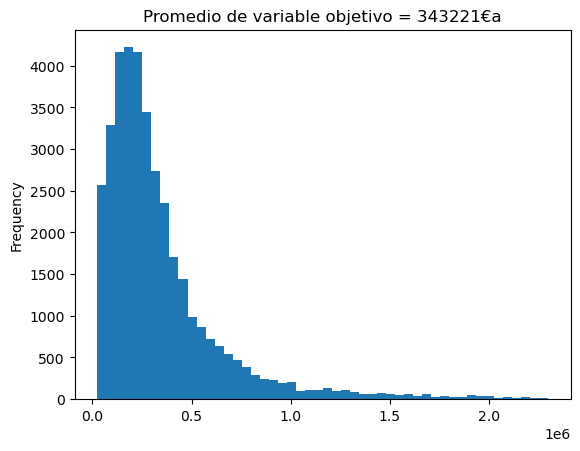

In [7]:
# skewed target
df["price"].plot(
    kind="hist", bins=50, title=f"Promedio de variable objetivo = {df['price'].mean():.0f}€a"
)

<AxesSubplot: title={'center': 'Promedio de variable objetivo = 12€a'}, ylabel='Frequency'>

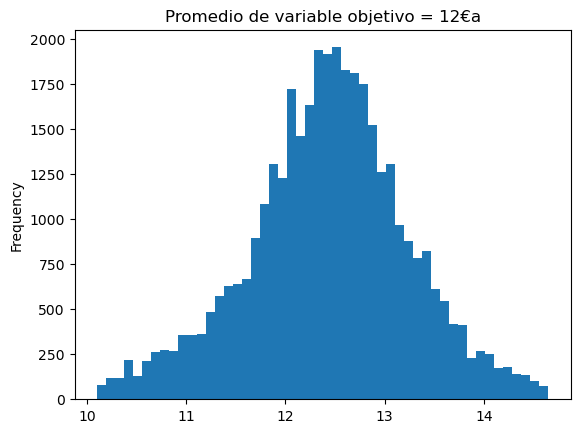

In [8]:
# skewed target
df["log_price"].plot(
    kind="hist", bins=50, title=f"Promedio de variable objetivo = {df['log_price'].mean():.0f}€a"
)

In [9]:
describe_datos(df)

,dtypes,null,nunique,unique
id_annonce,int64,0,37368,"[35996577, 35811033, 35731841, 35886765, 35781..."
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8643,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,int64,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,512,4478,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,27625,24,"[nan, 3.0, 5.0, 1.0, 2.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,21787,3721,"[nan, 370.0, 764.0, 25700.0, 392.0, 2600.0, 78..."
energy_performance_value,float64,18300,642,"[nan, 223.0, 217.0, 161.0, 193.0, 89.0, 220.0,..."


## Análisis exploratorio de datos.

De lo anterior podemos ver que para nuestros features sobresalen algunos aspectos, los cuales son:
- Gran cantidad de valores nulos en algunas columnas por lo que vamos a analizar como tratarlos.
- Columnas que deben de ser convertidas a datos categoricos, asi como ver algunas formas de tratarlos.
- Columnas que no nos van a aportar ninguna información por lo que pueden ser eliminadas.
- También vamos a tener que para property_type será para "house", floor será 0 y para "appartement", lot_size será 0.

In [10]:
columnas_con_nulos = df.columns[df.isna().any()].tolist()

# Ver el número de nulos por columna según tipo de propiedad
conteo_nulos_por_tipo = {}
for col in columnas_con_nulos:
    if col not in ['price']:  # Excluir price
        conteo_nulos_por_tipo[col] = X[X[col].isna()]['property_type'].value_counts()

# Detectar columnas binarias donde 0 podría ser una imputación válida
binarias_posibles = []
for col in columnas_con_nulos:
    if X[col].dropna().nunique() == 1 and X[col].dropna().unique()[0] == 0:
        binarias_posibles.append(col)

# Revisar también si hay columnas con nulos que están muy ligadas a un solo tipo de propiedad
conteo_nulos_por_tipo_df = pd.DataFrame(conteo_nulos_por_tipo).fillna(0).astype(int)
conteo_nulos_por_tipo_df

,size,floor,land_size,energy_performance_value,energy_performance_category,ghg_value,ghg_category,exposition,nb_rooms,nb_bedrooms,nb_bathrooms
property_type,,,,,,,,,,,
appartement,102,6135,15087,7984,7984,8156,8156,11291,56,1122,5870
atelier,0,2,2,1,1,1,1,0,0,0,0
chalet,1,48,6,22,22,22,22,29,1,0,10
chambre,0,2,4,3,3,3,3,4,0,4,1
château,0,21,3,14,14,14,14,14,0,0,5
divers,227,2137,1886,1769,1769,1776,1776,1993,1386,1462,1974
duplex,2,77,213,90,90,93,93,113,0,1,57
ferme,0,130,13,68,68,67,67,81,0,0,34
gîte,0,3,3,3,3,3,3,2,0,0,2


In [11]:
df.loc[(df['property_type'] != "appartement") & df['floor'].isna(), 'floor'] = 0          
df.loc[(df['property_type'] == "appartement") & df['land_size'].isna(), 'land_size'] = 0

In [12]:
cols_drop = ['nb_photos', 'energy_performance_category', 'ghg_category'] # Se eliminan las dos ultimas columnas porque hay una derivación 
                                                                                       # por otra columna que nos podría dar mas información.
df = df.drop(columns=cols_drop)

In [13]:
df['postal_code'] = df['postal_code'].astype('object') # Cambiamos el tipo de dato del codigo postal a categorico

In [14]:
# Imputar 'exposition' con 0 directamente
df['exposition'] = df['exposition'].fillna(0)

# Imputar otras con lógica basada en el tipo de propiedad
for col in ['nb_rooms', 'nb_bedrooms', 'nb_bathrooms']:
    # Si no es 'appartement' o 'maison', se asume que puede no tener esas características
    df.loc[df[col].isna() & (~df['property_type'].isin(['appartement', 'maison'])), col] = 0
    
    # Para el resto (viviendas), imputamos con la mediana por tipo de propiedad
    medianas = df.groupby('property_type')[col].median()
    for tipo, mediana in medianas.items():
        mask = df[col].isna() & (df['property_type'] == tipo)
        df.loc[mask, col] = mediana

In [15]:

df['energy_performance_value'] = df['energy_performance_value'].clip(upper=1000)
df['ghg_value'] = df['ghg_value'].clip(upper=150)
df['nb_rooms'] = df['nb_rooms'].clip(upper=20)
df['nb_bedrooms'] = df['nb_bedrooms'].clip(upper=10)
df['size'] = df['size'].clip(upper=2000)
df['land_size'] = df['land_size'].clip(upper=20000)

# Verificar nuevamente los valores nulos
nulos_post_clip = df.isna().sum().sort_values(ascending=False)
nulos_post_clip[nulos_post_clip > 0]

ghg_value                   18838
energy_performance_value    18300
land_size                    6700
floor                        6135
size                          512
dtype: int64

In [16]:
# Calcular la correlación de las columnas de interés con 'price'
correlaciones = df[['price', 'energy_performance_value', 'ghg_value']].corr()

# Extraer sólo la fila 'price'
correlaciones_price = correlaciones.loc['price'].drop('price')

correlaciones_price

energy_performance_value   -0.185836
ghg_value                  -0.024446
Name: price, dtype: float64

Eliminamos la columna ghg_value debido que parece que no aporta nada a nuestra variable predictoria

In [17]:
df = df.drop(columns=['ghg_value'])

In [18]:
# Imputar valores faltantes de 'energy_performance_value' con la mediana por tipo de propiedad
mediana_energia = df.groupby('property_type')['energy_performance_value'].median()
for tipo, mediana in mediana_energia.items():
    mask = df['energy_performance_value'].isna() & (df['property_type'] == tipo)
    df.loc[mask, 'energy_performance_value'] = mediana

# Imputar 'land_size', 'floor', 'size' con la mediana por tipo de propiedad
for col in ['land_size', 'floor', 'size']:
    medianas = df.groupby('property_type')[col].median()
    for tipo, mediana in medianas.items():
        mask = df[col].isna() & (df['property_type'] == tipo)
        df.loc[mask, col] = mediana

# Confirmar que ya no haya valores nulos
nulos_finales = df.isna().sum().sum()
nulos_finales

320

In [19]:
describe_datos(df)

,dtypes,null,nunique,unique
id_annonce,int64,0,37368,"[35996577, 35811033, 35731841, 35886765, 35781..."
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8643,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,object,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,0,1426,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,0,25,"[2.0, 3.0, 0.0, 5.0, 1.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,18,3434,"[0.0, 370.0, 764.0, 20000.0, 392.0, 754.0, 260..."
energy_performance_value,float64,302,619,"[173.0, 223.0, 188.0, 217.0, 161.0, 193.0, 89...."


Vamos a realizar algunas tasas de conversion y crearemos algunas columnas que podrian ayudarnos a mejorar el modelo predictivo.

In [20]:
# Crear nuevas variables derivadas
df["nb_bedrooms_over_rooms"] = df["nb_bedrooms"] / df["nb_rooms"].replace(0.0, np.nan)
df["size_over_rooms"] = df["size"] / df["nb_rooms"].replace(0.0, np.nan)
df["size_over_landsize"] = df["size"] / df["land_size"].replace(0.0, np.nan)
df["sqrt_size"] = np.sqrt(df["size"])

In [21]:
# Reemplazar los NaNs en las nuevas variables derivadas con 0
df["nb_bedrooms_over_rooms"] = df["nb_bedrooms_over_rooms"].fillna(0)
df["size_over_rooms"] = df["size_over_rooms"].fillna(0)
df["size_over_landsize"] = df["size_over_landsize"].fillna(0)

# Verificar que ya no hay valores nulos en esas columnas
print(df[['nb_bedrooms_over_rooms', 'size_over_rooms', 'size_over_landsize']].isna().sum())

nb_bedrooms_over_rooms    0
size_over_rooms           0
size_over_landsize        0
dtype: int64


In [22]:
# Eliminar filas con valores nulos en las columnas específicas
df = df.dropna(subset=['land_size', 'energy_performance_value'])

# Verificar que ya no haya nulos en esas columnas
print(df[['land_size', 'energy_performance_value']].isna().sum())

# Mostrar también el nuevo tamaño del dataset
df.shape

land_size                   0
energy_performance_value    0
dtype: int64


(37052, 29)

In [23]:
describe_datos(df)

,dtypes,null,nunique,unique
id_annonce,int64,0,37052,"[35996577, 35811033, 35731841, 35886765, 35781..."
property_type,object,0,16,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37052,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37052,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8552,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,object,0,4716,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,0,1381,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,0,25,"[2.0, 3.0, 0.0, 5.0, 1.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,0,3402,"[0.0, 370.0, 764.0, 20000.0, 392.0, 754.0, 260..."
energy_performance_value,float64,0,619,"[173.0, 223.0, 188.0, 217.0, 161.0, 193.0, 89...."


## Análisis de correlaciones.

<Figure size 640x480 with 0 Axes>

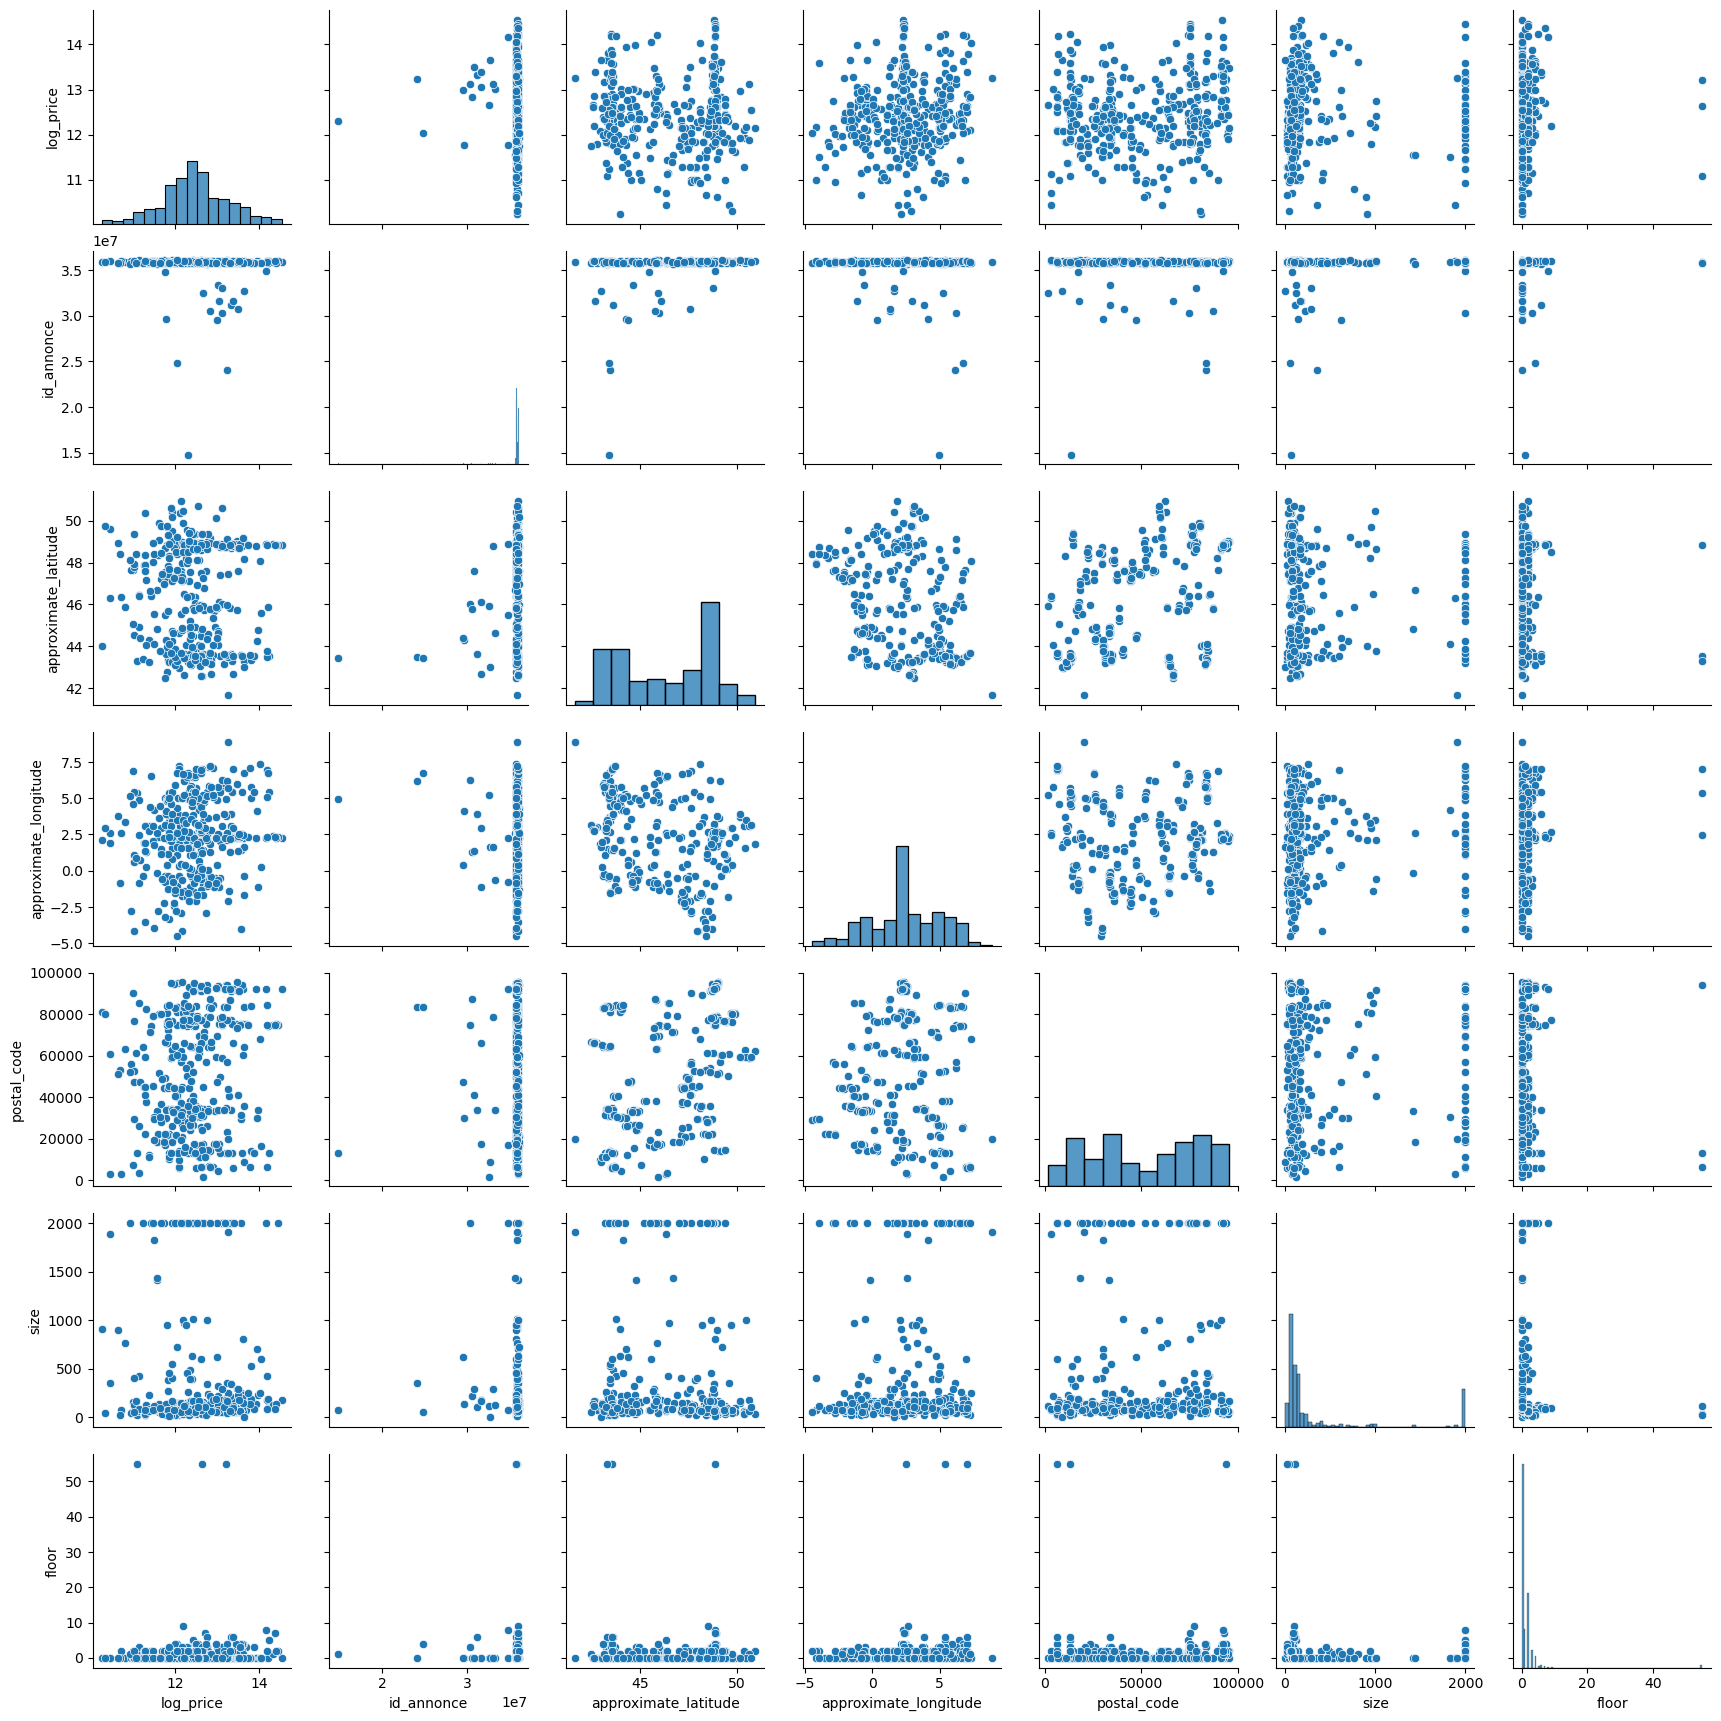

<Figure size 640x480 with 0 Axes>

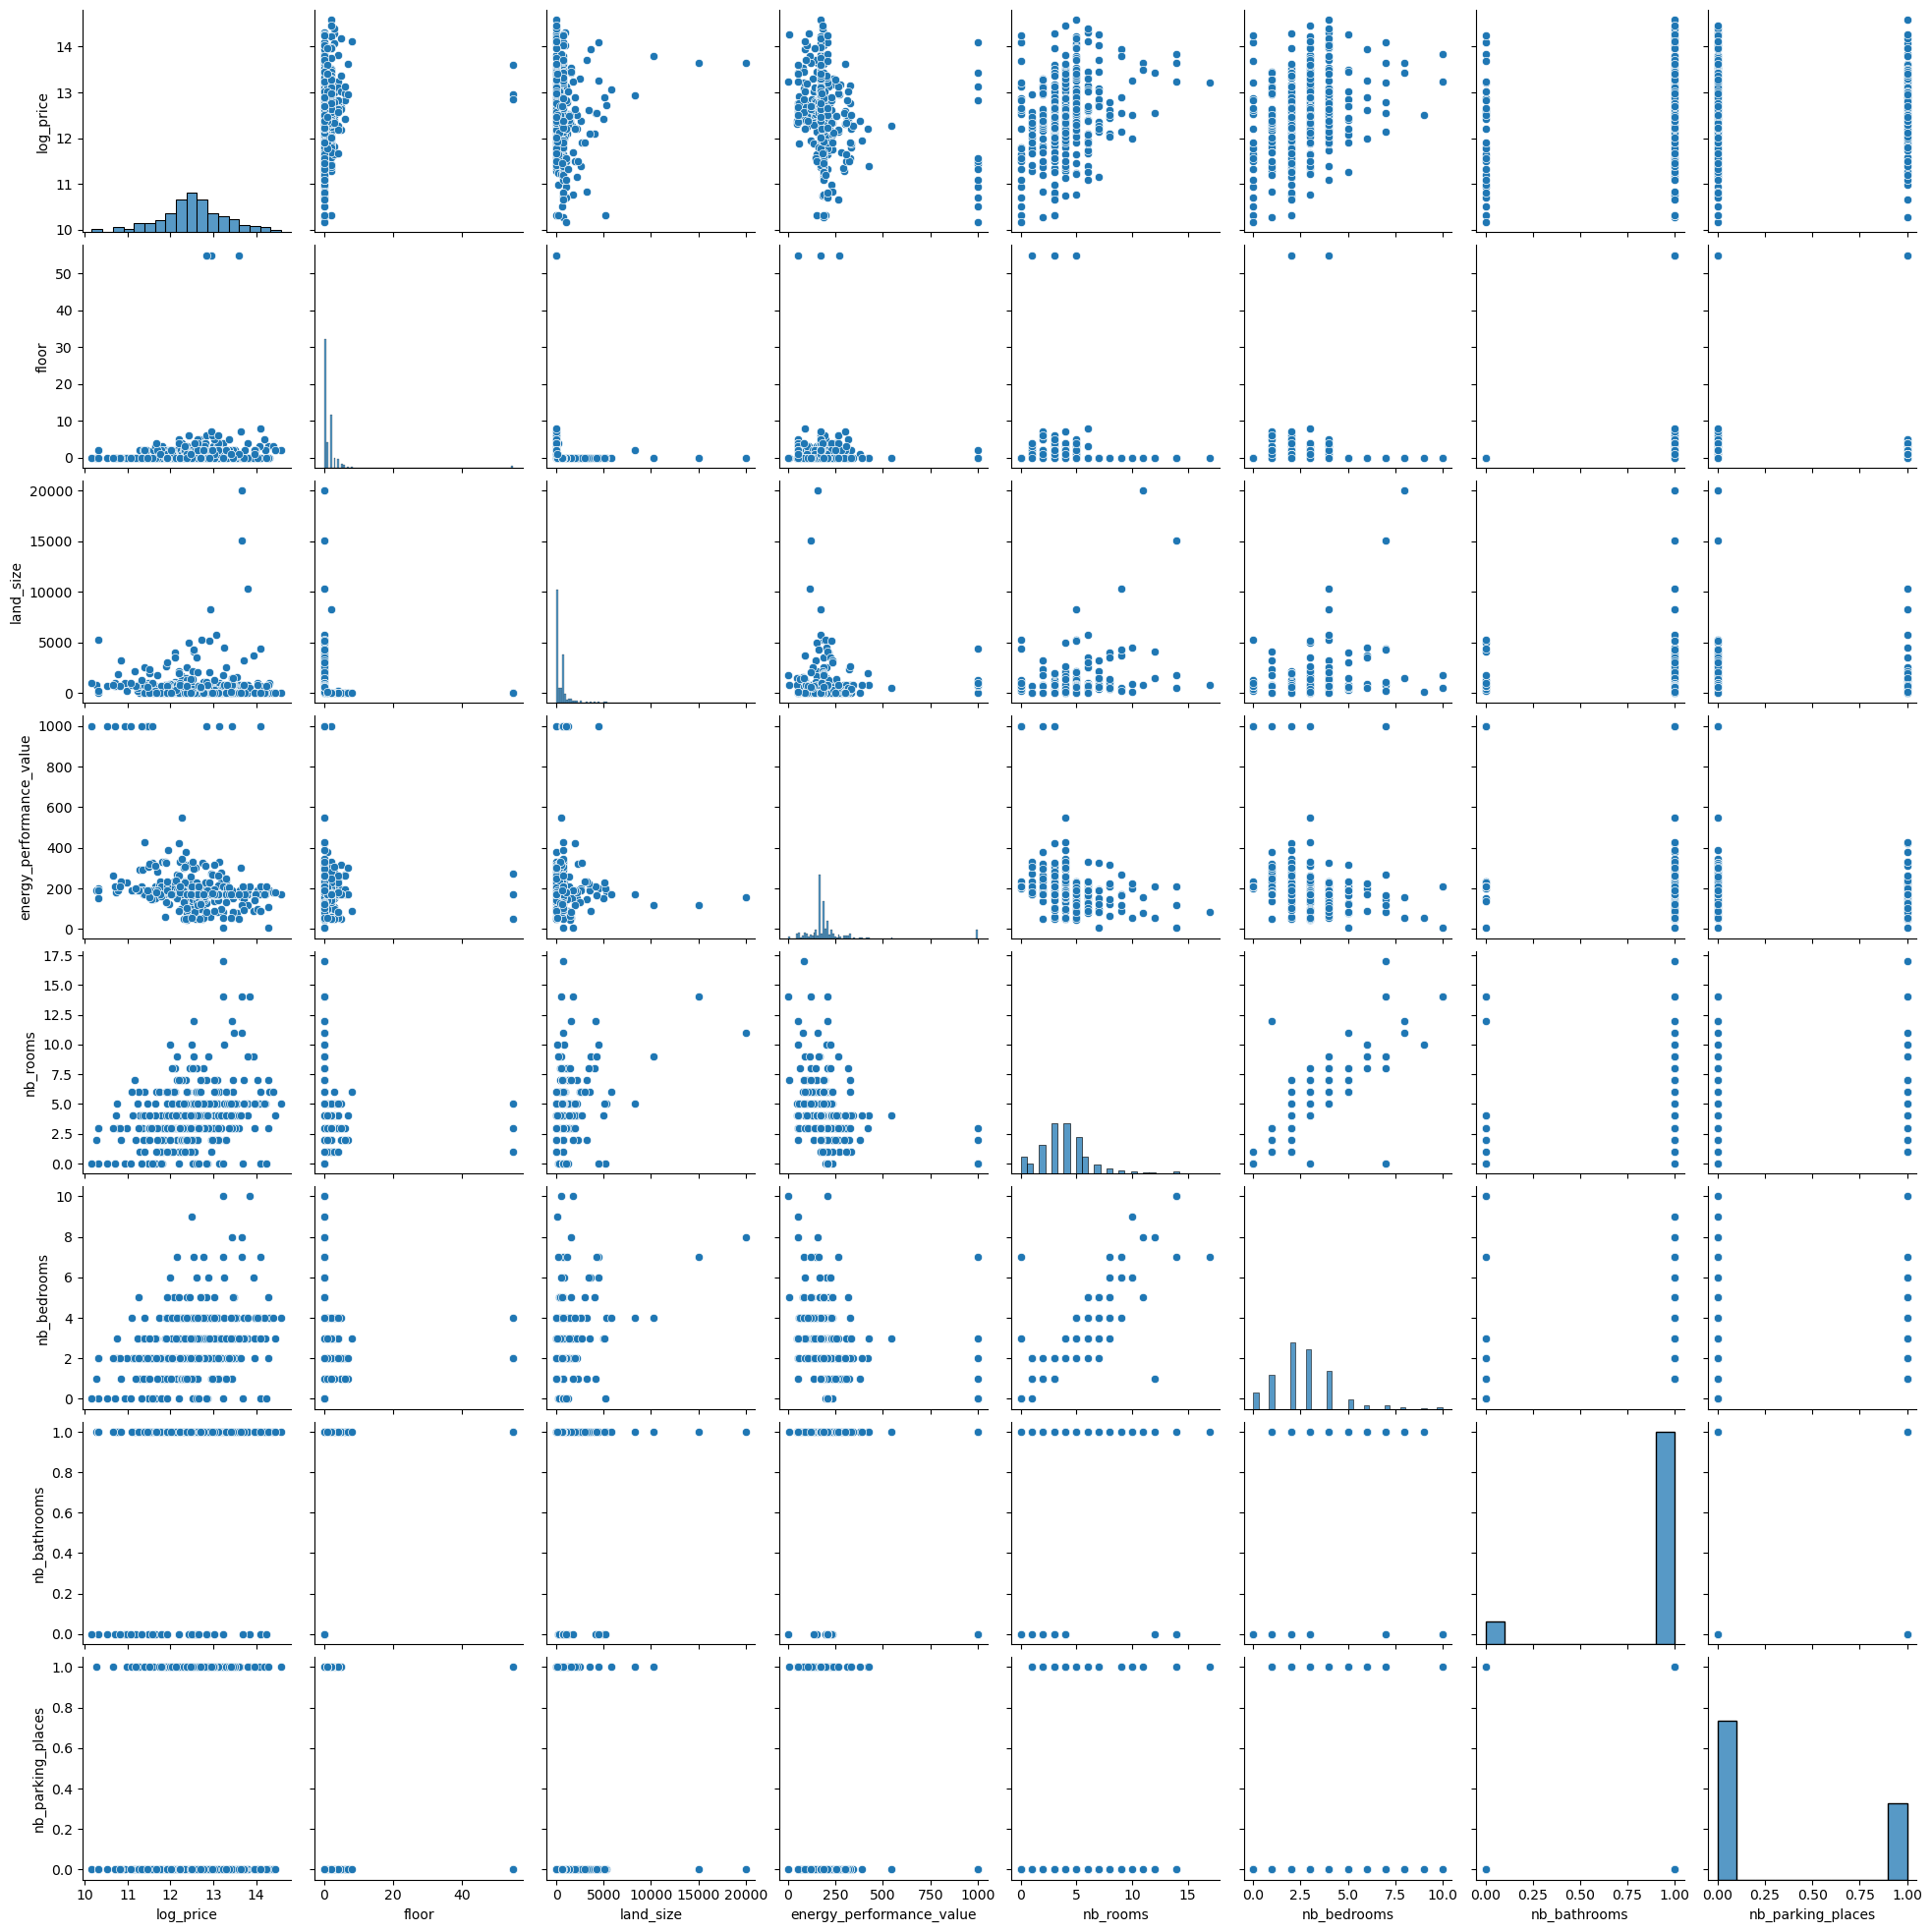

<Figure size 640x480 with 0 Axes>

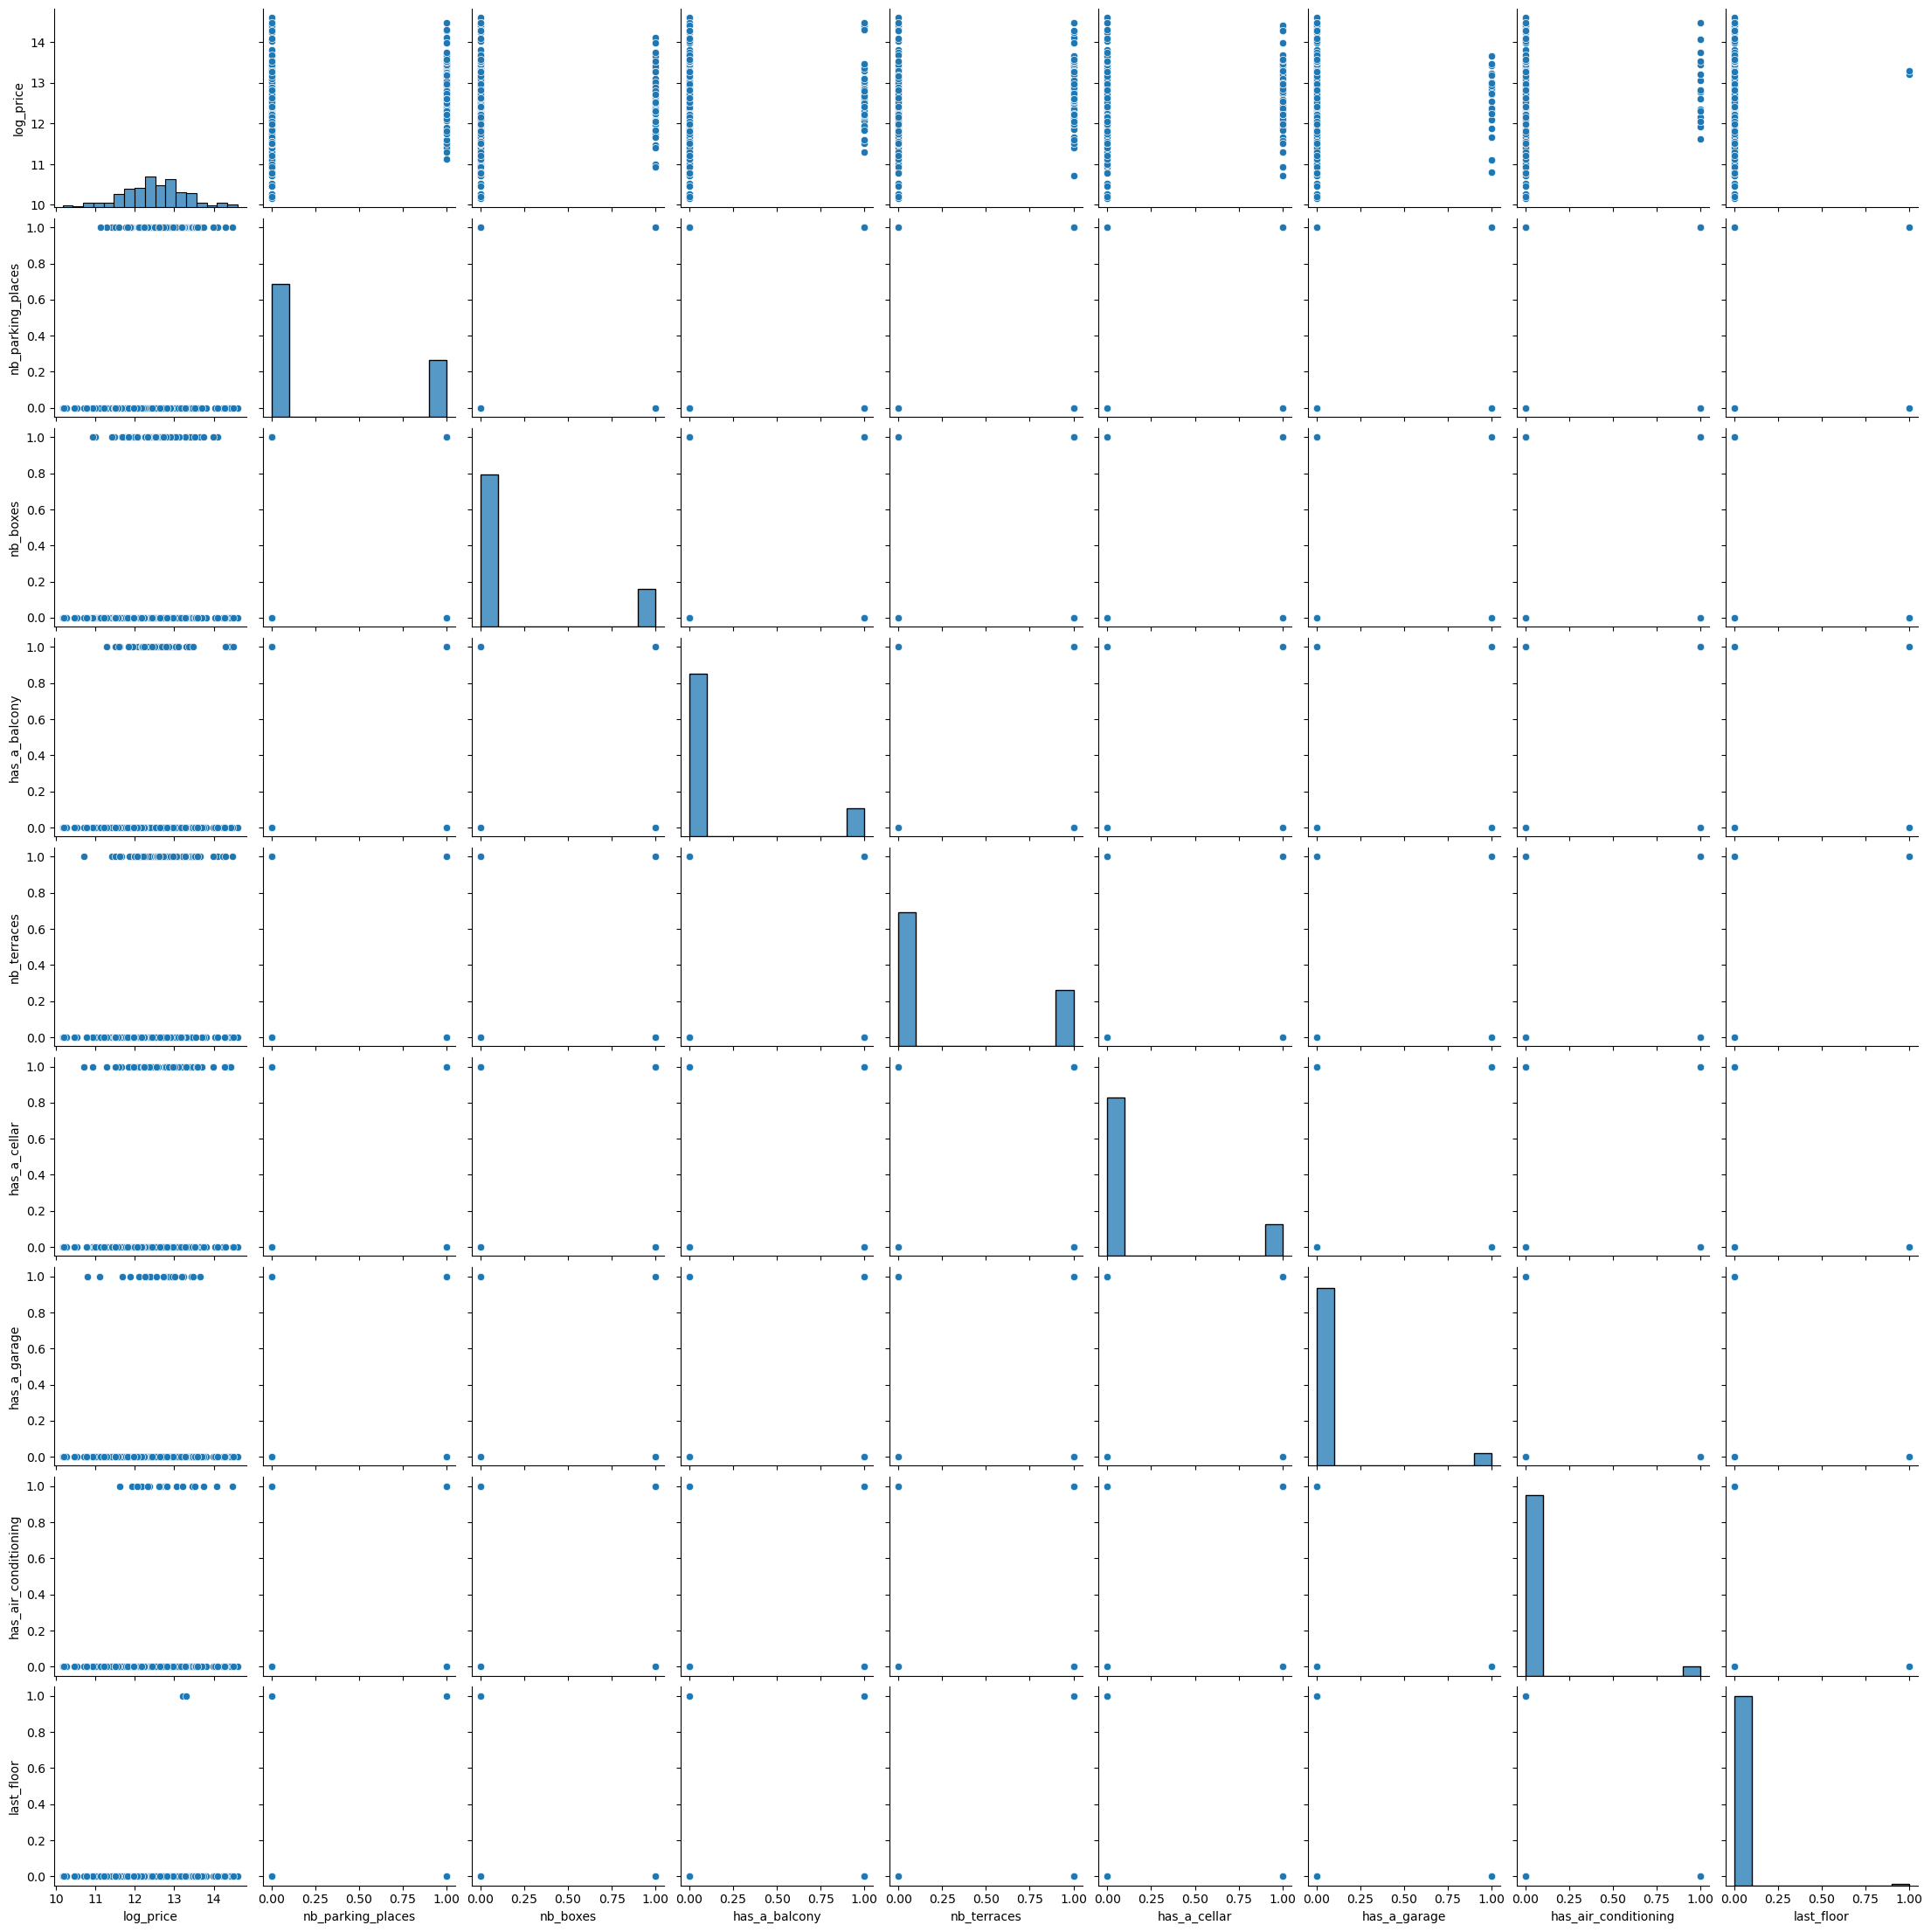

<Figure size 640x480 with 0 Axes>

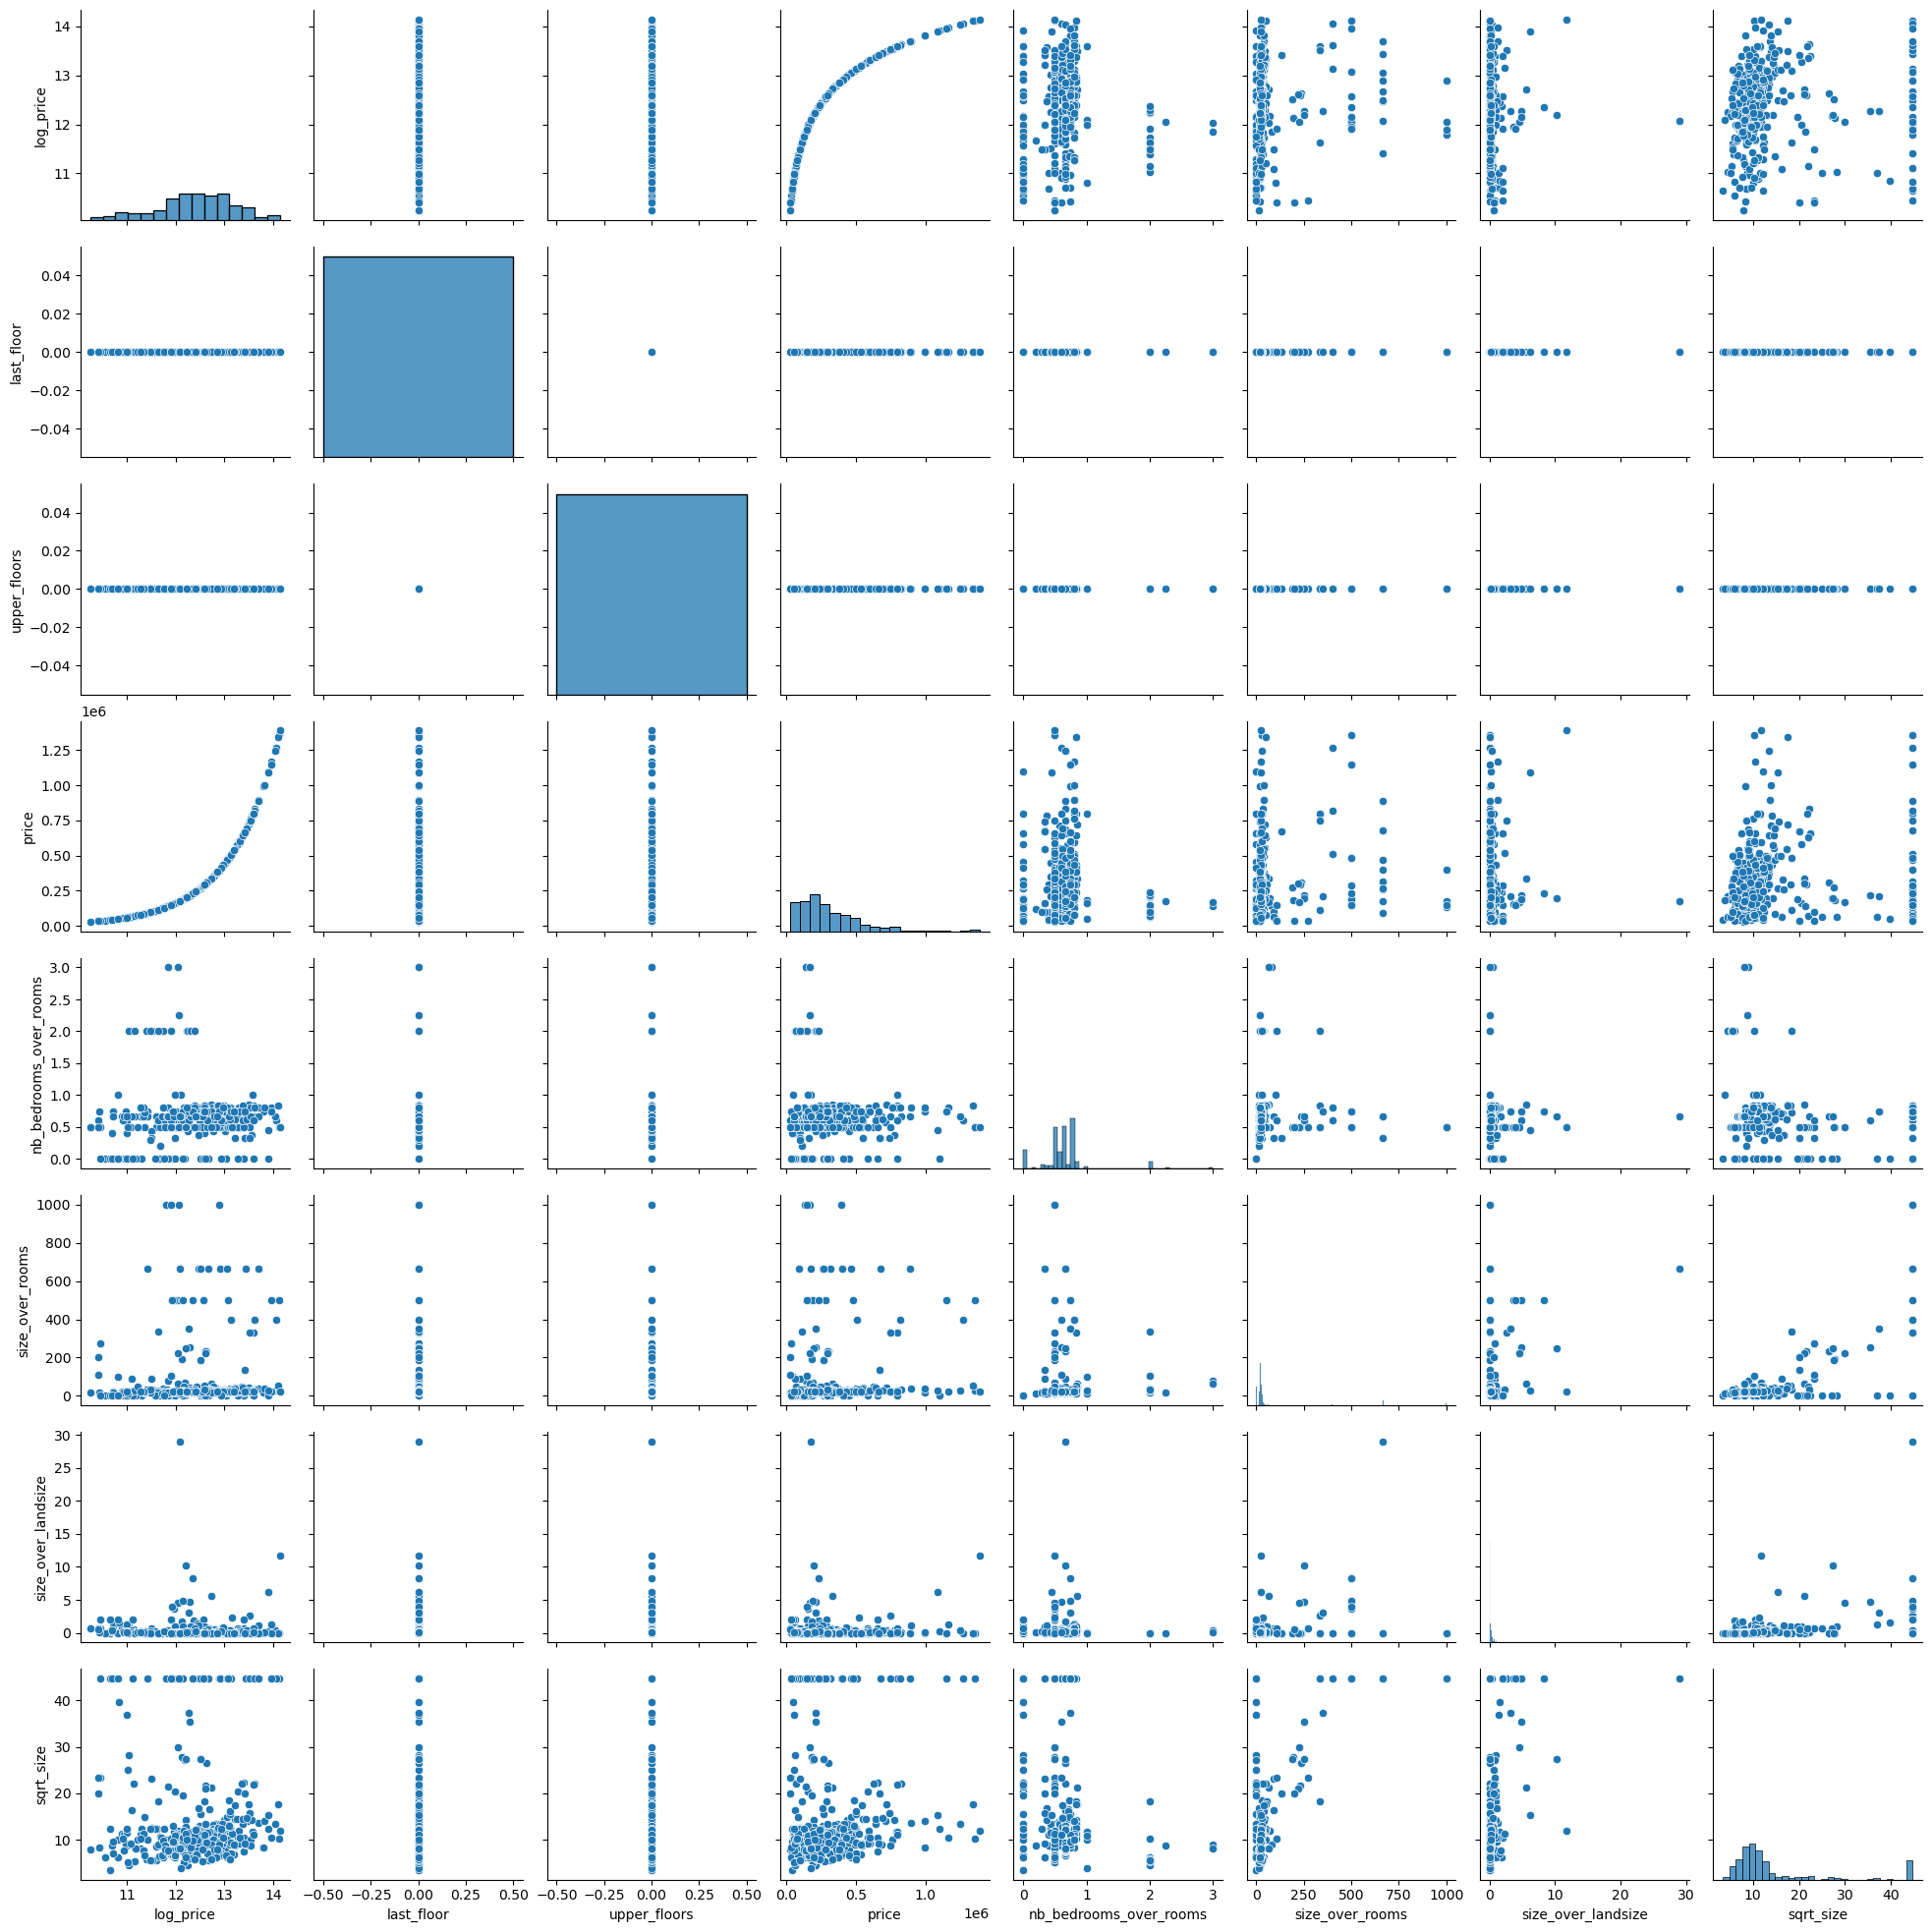

In [24]:
for i in range(4):
    columns_subset = ["log_price"] + [
        c
        for k, c in enumerate(df.columns)
        if i * 7 <= k <= (i + 1) * 7 and c != "log_price"
    ]
    data_subset = df[columns_subset].sample(df.shape[0] // 100)

    plt.figure()
    sns.pairplot(data_subset)
    plt.show()

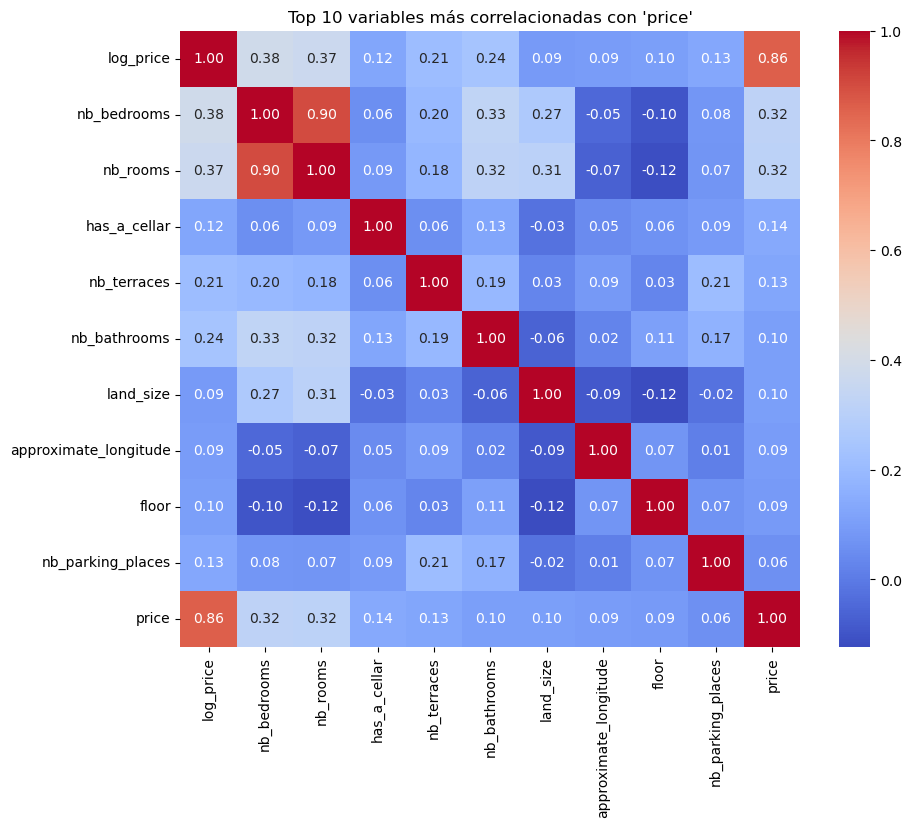

log_price                   0.859823
nb_bedrooms                 0.319178
nb_rooms                    0.315884
has_a_cellar                0.138555
nb_terraces                 0.126785
nb_bathrooms                0.104789
land_size                   0.101730
approximate_longitude       0.094289
floor                       0.091498
nb_parking_places           0.061310
has_a_balcony               0.060202
sqrt_size                   0.059464
has_air_conditioning        0.055814
last_floor                  0.048213
has_a_garage                0.039552
approximate_latitude        0.034752
nb_bedrooms_over_rooms      0.031862
nb_boxes                    0.028291
size                        0.022070
size_over_landsize          0.013164
upper_floors               -0.005655
id_annonce                 -0.013907
size_over_rooms            -0.020850
energy_performance_value   -0.195669
Name: price, dtype: float64

In [25]:
# Calcular la matriz de correlación solo para columnas numéricas
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Extraer correlación con la variable objetivo 'price' y ordenarla
correlaciones_con_price = corr_matrix['price'].drop('price').sort_values(ascending=False)

# Visualizar con un heatmap sólo las 10 más correlacionadas
top_corr = correlaciones_con_price.head(10).index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr + ['price']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Top 10 variables más correlacionadas con 'price'")
plt.show()

correlaciones_con_price

## Entrenamiento del modelo

In [26]:
# Variables numéricas (excepto columnas que no se deben usar como features)
columnas_excluir = ['id_annonce', 'price', 'log_price']
X = df.select_dtypes(include=[np.number]).drop(columns=columnas_excluir)
y = df['log_price']

In [27]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 261)

In [28]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (27789, 22)
y:  (27789,)
Conjunto de prueba
X:  (9263, 22)
y:  (9263,)


In [29]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Calculamos el error medio absoluto (MAE)
error_medio_absoluto = np.mean(np.absolute(y_test - y_pred))
error_medio_absoluto

0.5059594830201495

In [37]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.651711439085

In [30]:
# Calculamos los errores:
errores = (y_test - y_pred)
len(errores)

9263

In [31]:
errores[:20]

34423    0.199009
25791    0.967802
16363   -0.266155
6388     0.097446
18536   -0.794826
33879   -0.267410
35401   -0.678733
20998   -0.562794
7258     0.442300
19487    0.306949
2140     0.080404
6778    -0.490119
11258    0.612048
15988    1.024653
12229   -0.042300
35842   -0.323046
24351    0.284990
17606    0.292013
34252   -0.740022
31079   -0.283201
Name: log_price, dtype: float64

In [43]:
print(f'Kurtosis: {kurtosis(errores)}')

Kurtosis: 0.365533233633593


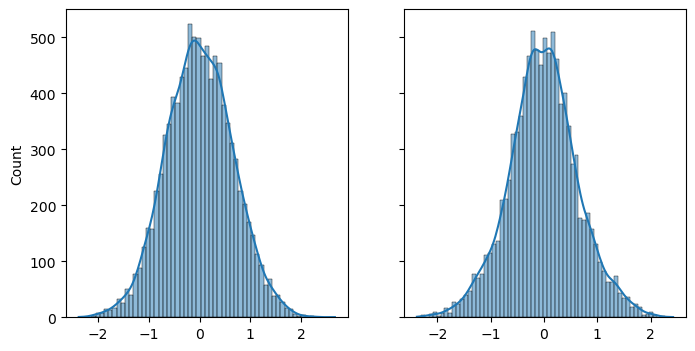

In [32]:
# Comparación de la distribución teórica(normal) y empirica de los errores

media = np.mean(errores)
des_est = np.std(errores)
errores_teoricos = np.random.normal(media, des_est, 10000)
muestra_errores = np.random.choice(errores, 10000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, muestra_errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

## Regresión robusta (Huber Regressor)

In [40]:
hr = HuberRegressor(epsilon = 1, max_iter = 1000, alpha = 0, warm_start = False, fit_intercept = True, tol = 1e-05)
hr = hr.fit(X_train, y_train)
y_pred_hr = hr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hr))

MAE: 0.6404493517593


In [42]:
#calculamos los errores
errores_hr = (y_test - y_pred_hr)

print(f'kurtosis: {kurtosis(errores_hr)}')

kurtosis: 0.018630264628891613
